# Predicting Hotel Cancellations

## 🏨 Background

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

## Executive Summary

In [1]:
pip install autogluon

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from autogluon.tabular import TabularDataset, TabularPredictor

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)  
plt.style.use('ggplot')
%matplotlib inline

## The Data

They have provided you with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [3]:
hotels = pd.read_csv("data/hotel_bookings.csv")
display(hotels)
hotels.shape

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3.0,0.0,2.0,NaN,Meal Plan 1,0.0,NaN,85.0,2018.0,8.0,3.0,Online,NaN,0.0,0.0,167.80,1.0,Not_Canceled
36271,INN36272,2.0,0.0,1.0,3.0,Meal Plan 1,0.0,Room_Type 1,228.0,2018.0,10.0,17.0,Online,0.0,0.0,0.0,90.95,2.0,Canceled
36272,INN36273,2.0,0.0,2.0,6.0,Meal Plan 1,0.0,Room_Type 1,148.0,2018.0,7.0,1.0,Online,0.0,0.0,0.0,98.39,2.0,Not_Canceled
36273,INN36274,2.0,0.0,0.0,3.0,Not Selected,0.0,Room_Type 1,63.0,2018.0,4.0,21.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


(36275, 19)

In [4]:
np.round(hotels.isnull().sum()/len(hotels) *100,3).astype(str) + ['%']

Booking_ID                                0.0%
no_of_adults                            1.139%
no_of_children                          0.893%
no_of_weekend_nights                    1.012%
no_of_week_nights                       2.225%
type_of_meal_plan                        1.45%
required_car_parking_space              7.145%
room_type_reserved                      3.228%
lead_time                               1.301%
arrival_year                            1.042%
arrival_month                           1.389%
arrival_date                            2.704%
market_segment_type                     4.168%
repeated_guest                          1.615%
no_of_previous_cancellations             1.37%
no_of_previous_bookings_not_canceled    1.516%
avg_price_per_room                      1.268%
no_of_special_requests                  2.175%
booking_status                            0.0%
dtype: object

In [5]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          35862 non-null  float64
 2   no_of_children                        35951 non-null  float64
 3   no_of_weekend_nights                  35908 non-null  float64
 4   no_of_week_nights                     35468 non-null  float64
 5   type_of_meal_plan                     35749 non-null  object 
 6   required_car_parking_space            33683 non-null  float64
 7   room_type_reserved                    35104 non-null  object 
 8   lead_time                             35803 non-null  float64
 9   arrival_year                          35897 non-null  float64
 10  arrival_month                         35771 non-null  float64
 11  arrival_date   

In [6]:
hotels.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,35862.000000,35951.000000,35908.000000,35468.00000,33683.000000,35803.000000,35897.000000,35771.000000,35294.000000,35689.000000,35778.000000,35725.000000,35815.000000,35486.000000
mean,1.845017,0.105366,0.810209,2.20331,0.030698,85.276569,2017.820431,7.424031,15.605712,0.025666,0.023646,0.154458,103.418207,0.619343
std,0.518652,0.402871,0.870857,1.40989,0.172501,85.998845,0.383834,3.068277,8.743484,0.158140,0.370835,1.764805,35.057342,0.785849
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.00000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.00000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.00000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.00000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


## EDA

In [7]:
# plot features using countplot
def countplot_features(title, *args):
    nrows= int(np.ceil(len(*args)/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(10,5), constrained_layout=True)
    ax = ax.ravel()
    for i, col in enumerate(*args):
        sns.countplot(data=hotels, x=col, ax=ax[i], hue='booking_status', palette= 'mako')
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, fontsize='small')
        ax[i].set_xlabel(col.replace('_', ' ').capitalize(), fontsize=15)
    plt.suptitle(title, fontsize=15)

In [8]:
# making canceled and not canceled ratio and percentage from total data set
def ratio_percetage_cal(col=None):
    temp = hotels.groupby([col,'booking_status'])['booking_status'].count().unstack()
    temp = temp.replace(np.nan,0)
    temp['row_sum'] = temp.sum(axis=1)
    temp['Canceled_ratio'] = np.round(temp['Canceled']/ temp['row_sum'] *100, 2)
    temp['Not_Canceled_ratio'] = np.round(temp['Not_Canceled']/ temp['row_sum'] *100, 2)
    temp['Percentage of data'] = np.round(temp['row_sum']/ len(hotels) * 100,2)
    return temp

In [9]:
def show_ratio(*args):
    for i, col in enumerate(*args):
        print(col.replace('_',' ').upper())
        print(ratio_percetage_cal(col).iloc[:,-3:])
        print('___________________________________________________________________________')

### How many of custemrs were canceled? 

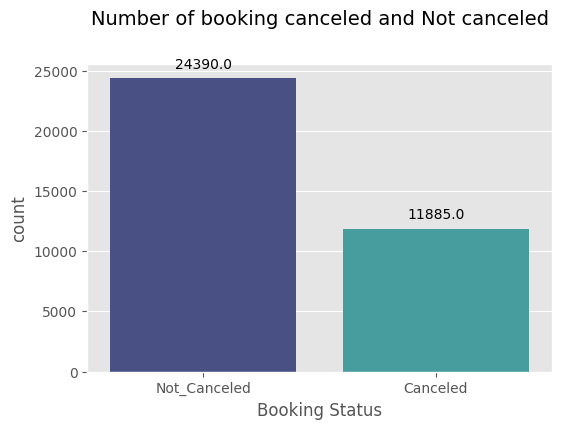

In [10]:
plt.figure(figsize=(6,4))
bplot = sns.countplot(data=hotels, x='booking_status', palette='mako')
for p in bplot.patches:
        bplot.annotate(p.get_height(),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 10),
                       textcoords = 'offset points') 
plt.xlabel('Booking Status')
plt.title('Number of booking canceled and Not canceled', fontsize = 14, x=0.5, y=1.1)
plt.show()

In [11]:
# change float type features to object type
cols = ['required_car_parking_space', 'arrival_year', 'repeated_guest']
check_values = {}
for i, col in enumerate(cols):
    check_values[col] = None
    check_values[col] =[hotels[col].astype('str').unique(),[hotels[col].astype('str').nunique()]]
    
display(pd.DataFrame(check_values))
hotels[cols] = hotels[cols].astype('str')

,required_car_parking_space,arrival_year,repeated_guest
0,"[nan, 0.0, 1.0]","[nan, 2018.0, 2017.0]","[nan, 0.0, 1.0]"
1,[3],[3],[3]


### Does a certain number of customers cancel more than others?

NO OF ADULTS
booking_status  Canceled_ratio  Not_Canceled_ratio  Percentage of data
no_of_adults                                                          
0.0                      30.66               69.34                0.38
1.0                      24.10               75.90               20.97
2.0                      34.92               65.08               71.16
3.0                      37.21               62.79                6.31
4.0                      18.75               81.25                0.04
___________________________________________________________________________
NO OF CHILDREN
booking_status  Canceled_ratio  Not_Canceled_ratio  Percentage of data
no_of_children                                                        
0.0                      32.40               67.60               91.73
1.0                      33.33               66.67                4.42
2.0                      43.47               56.53                2.89
3.0                      26.32              

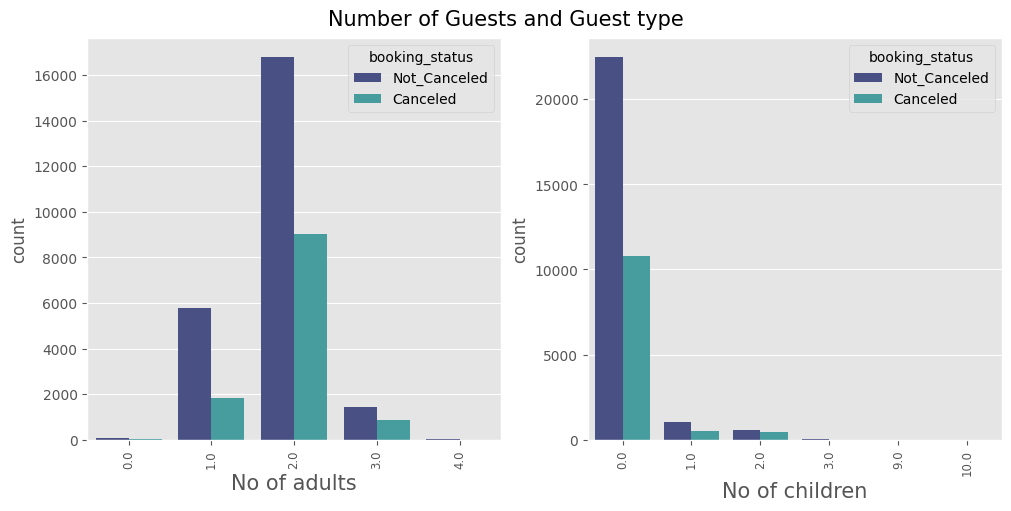

In [12]:
num_guests = ['no_of_adults', 'no_of_children']
show_ratio(num_guests)
countplot_features('Number of Guests and Guest type',num_guests)

### When do customers cancel during the week or the weekend?

NO OF WEEKEND NIGHTS
booking_status        Canceled_ratio  Not_Canceled_ratio  Percentage of data
no_of_weekend_nights                                                        
0.0                            30.18               69.82               46.08
1.0                            34.41               65.59               27.26
2.0                            34.87               65.13               24.73
3.0                            48.03               51.97                0.42
4.0                            64.06               35.94                0.35
5.0                            85.29               14.71                0.09
6.0                            80.00               20.00                0.06
7.0                           100.00                0.00                0.00
___________________________________________________________________________
NO OF WEEK NIGHTS
booking_status     Canceled_ratio  Not_Canceled_ratio  Percentage of data
no_of_week_nights                        

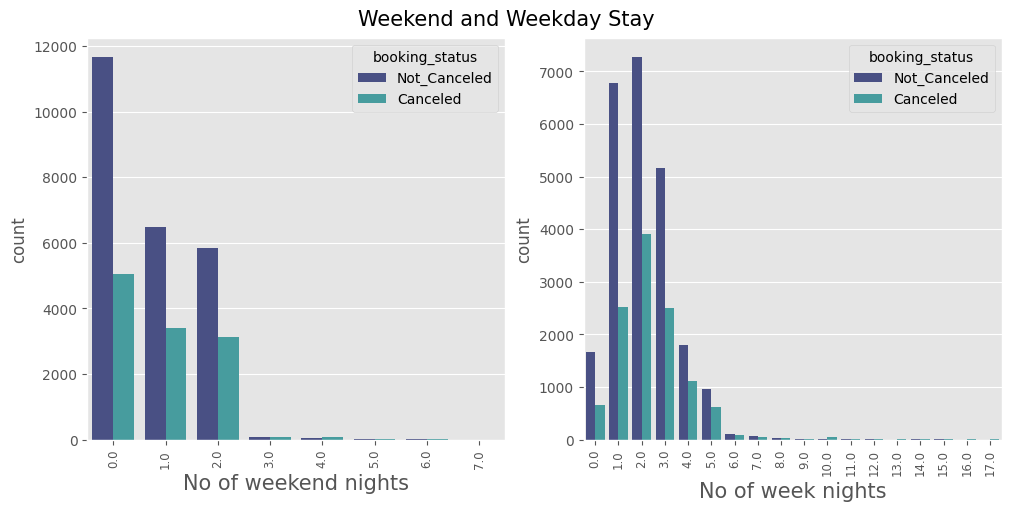

In [13]:
stay_types = ['no_of_weekend_nights','no_of_week_nights']
show_ratio(stay_types)
countplot_features('Weekend and Weekday Stay',stay_types)


### Is there seasonal or monthly effect on cancelation ?

ARRIVAL YEAR
booking_status  Canceled_ratio  Not_Canceled_ratio  Percentage of data
arrival_year                                                          
2017.0                   14.77               85.23               17.77
2018.0                   36.73               63.27               81.19
nan                      30.69               69.31                1.04
___________________________________________________________________________
ARRIVAL MONTH
booking_status  Canceled_ratio  Not_Canceled_ratio  Percentage of data
arrival_month                                                         
1.0                       2.40               97.60                2.76
2.0                      25.42               74.58                4.60
3.0                      29.77               70.23                6.42
4.0                      36.44               63.56                7.44
5.0                      36.68               63.32                7.07
6.0                      40.26               

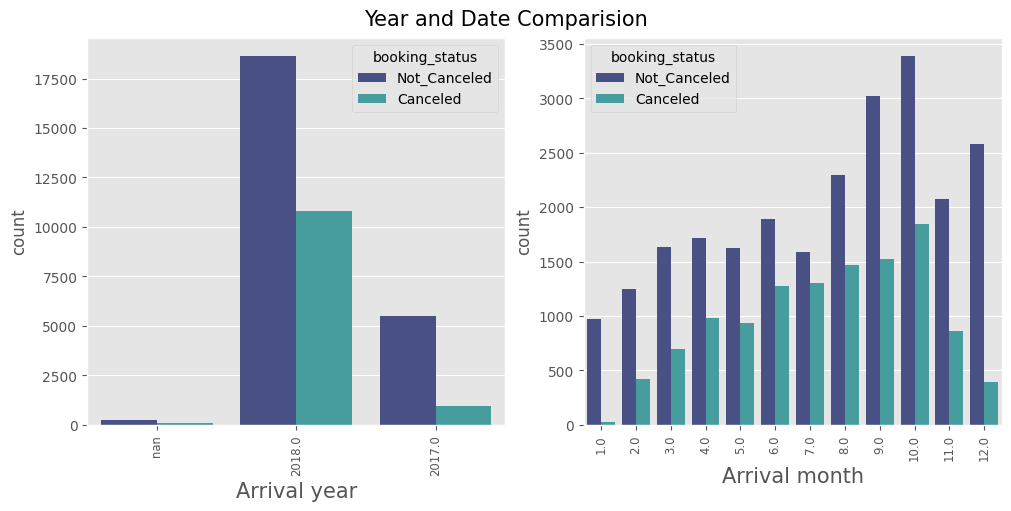

In [14]:
date_features = ['arrival_year', 'arrival_month']
show_ratio(date_features)
countplot_features('Year and Date Comparision',date_features)

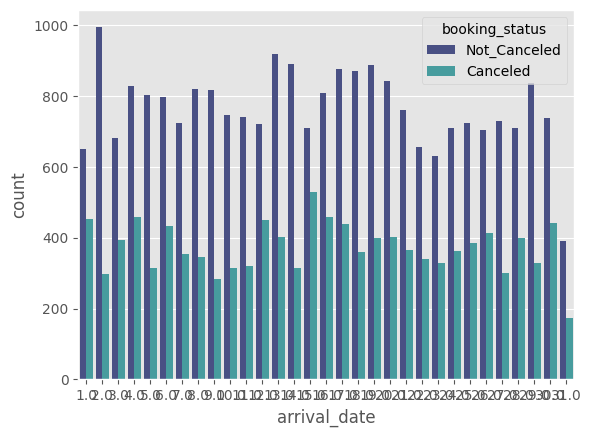

In [15]:
sns.countplot(data=hotels, x='arrival_date', palette='mako', hue='booking_status')
plt.show()

### Is any relation between the customer's request and the cancellation?

TYPE OF MEAL PLAN
booking_status     Canceled_ratio  Not_Canceled_ratio  Percentage of data
type_of_meal_plan                                                        
Meal Plan 1                 31.15               68.85               75.59
Meal Plan 2                 45.56               54.44                9.00
Meal Plan 3                 20.00               80.00                0.01
Not Selected                33.18               66.82               13.94
___________________________________________________________________________
REQUIRED CAR PARKING SPACE
booking_status              Canceled_ratio  Not_Canceled_ratio  \
required_car_parking_space                                       
0.0                                  33.41               66.59   
1.0                                  10.25               89.75   
nan                                  33.56               66.44   

booking_status              Percentage of data  
required_car_parking_space                      
0.0   

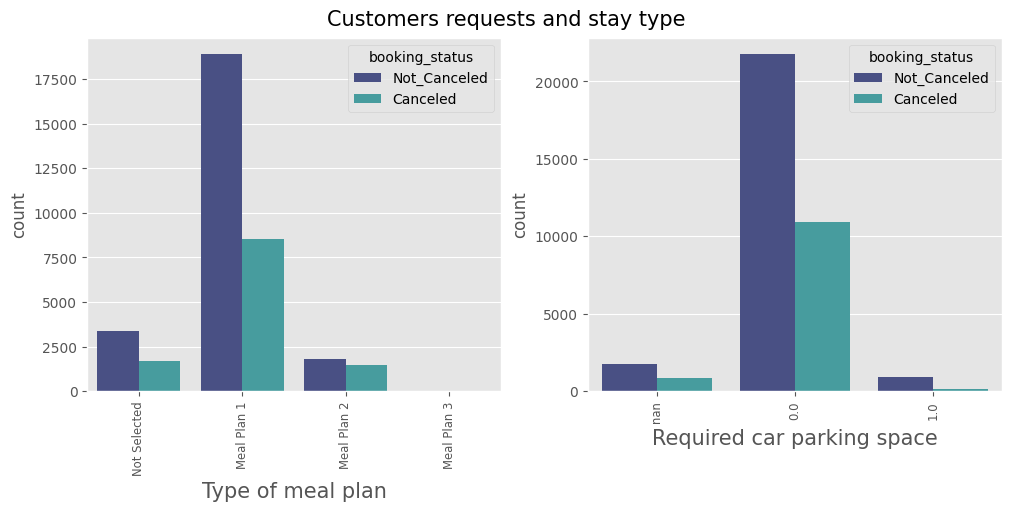

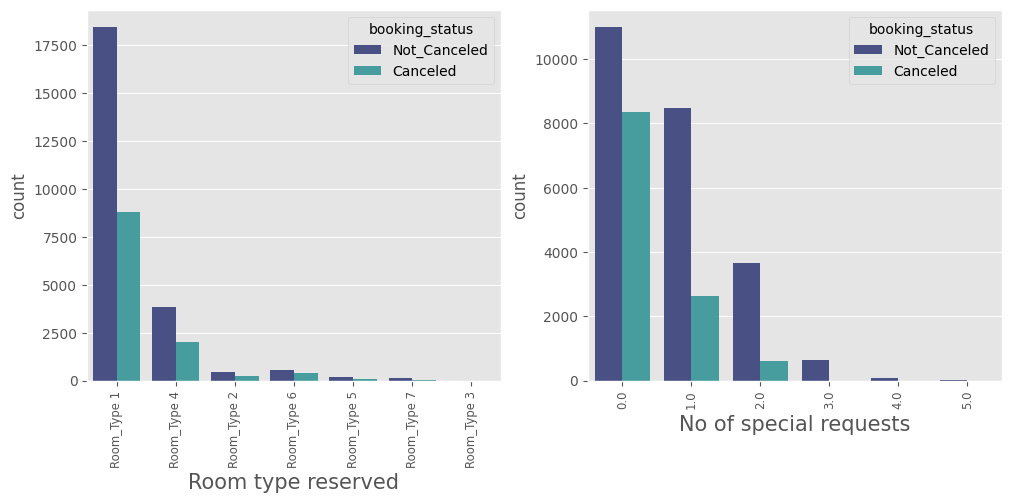

In [16]:
requests = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'no_of_special_requests']
show_ratio(requests)
countplot_features('Customers requests and stay type',requests[:2])
countplot_features('',requests[2:])

### Does frequency of previous cancelation have any relation with cancelation of current booking?

NO OF PREVIOUS CANCELLATIONS
booking_status                Canceled_ratio  Not_Canceled_ratio  \
no_of_previous_cancellations                                       
0.0                                    33.04               66.96   
1.0                                     5.58               94.42   
2.0                                     0.00              100.00   
3.0                                     2.33               97.67   
4.0                                     0.00              100.00   
5.0                                     0.00              100.00   
6.0                                     0.00              100.00   
11.0                                    0.00              100.00   
13.0                                  100.00                0.00   

booking_status                Percentage of data  
no_of_previous_cancellations                      
0.0                                        97.70  
1.0                                         0.54  
2.0               

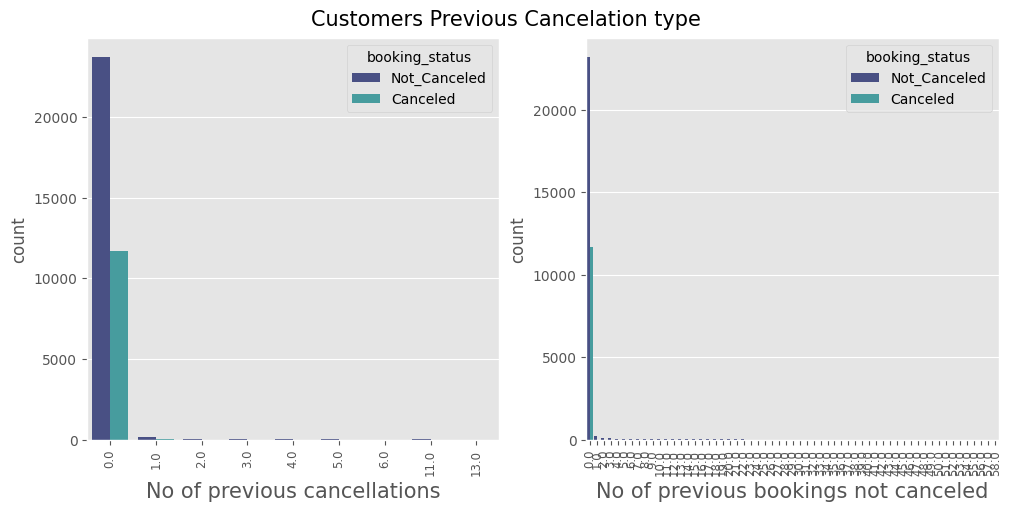

In [17]:
previous =[ 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled']
show_ratio(previous)
countplot_features('Customers Previous Cancelation type', previous)

### Customers's booking type

REPEATED GUEST
booking_status  Canceled_ratio  Not_Canceled_ratio  Percentage of data
repeated_guest                                                        
0.0                      33.60               66.40               95.86
1.0                       1.75               98.25                2.53
nan                      31.57               68.43                1.62
___________________________________________________________________________
MARKET SEGMENT TYPE
booking_status       Canceled_ratio  Not_Canceled_ratio  Percentage of data
market_segment_type                                                        
Aviation                      29.51               70.49                0.34
Complementary                  0.00              100.00                1.03
Corporate                     10.59               89.41                5.31
Offline                       30.00               70.00               27.78
Online                        36.58               63.42               61.38
__

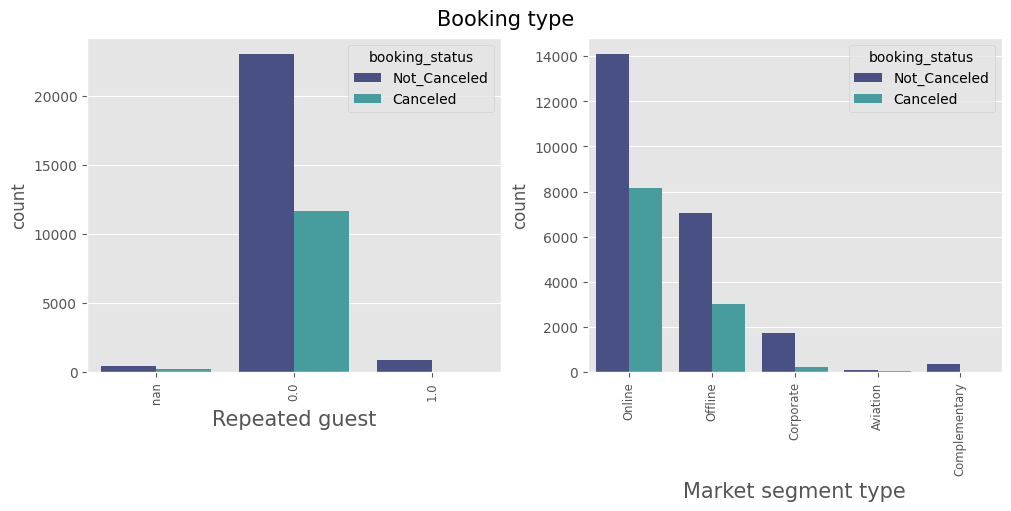

In [18]:
booking_type =['repeated_guest', 'market_segment_type']
show_ratio(booking_type)
countplot_features('Booking type', booking_type)

### Cancelations with Lead time and Avearage price per room

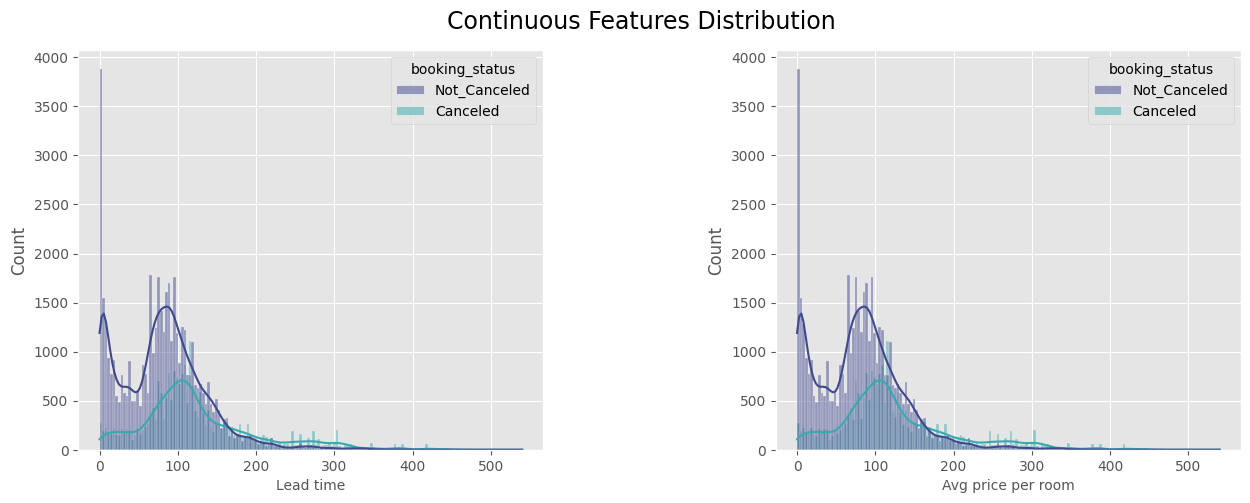

In [19]:
continuous_features = ['lead_time', 'avg_price_per_room']
hotels_long = pd.melt(hotels, id_vars=['booking_status'], value_vars=continuous_features, var_name='feature')
fig, axes = plt.subplots(1, 2, figsize=(15,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.5, hspace=0.75)
for i, col in enumerate(continuous_features):
    row = 1
    col_idx = i % 2
    sns.histplot(data=hotels_long, x='value', kde=True, ax=axes[col_idx], palette='mako', hue='booking_status')
    axes[col_idx].set_xlabel(col.replace('_', ' ').capitalize(), fontsize =10)
plt.suptitle('Continuous Features Distribution', fontsize=17)
plt.show()

In [20]:
cat_cols = [i for i in hotels.columns if hotels[i].dtype =='object']
num_cols = [i for i in hotels.columns if hotels[i].dtype !='object']
cat_cols.remove('Booking_ID')

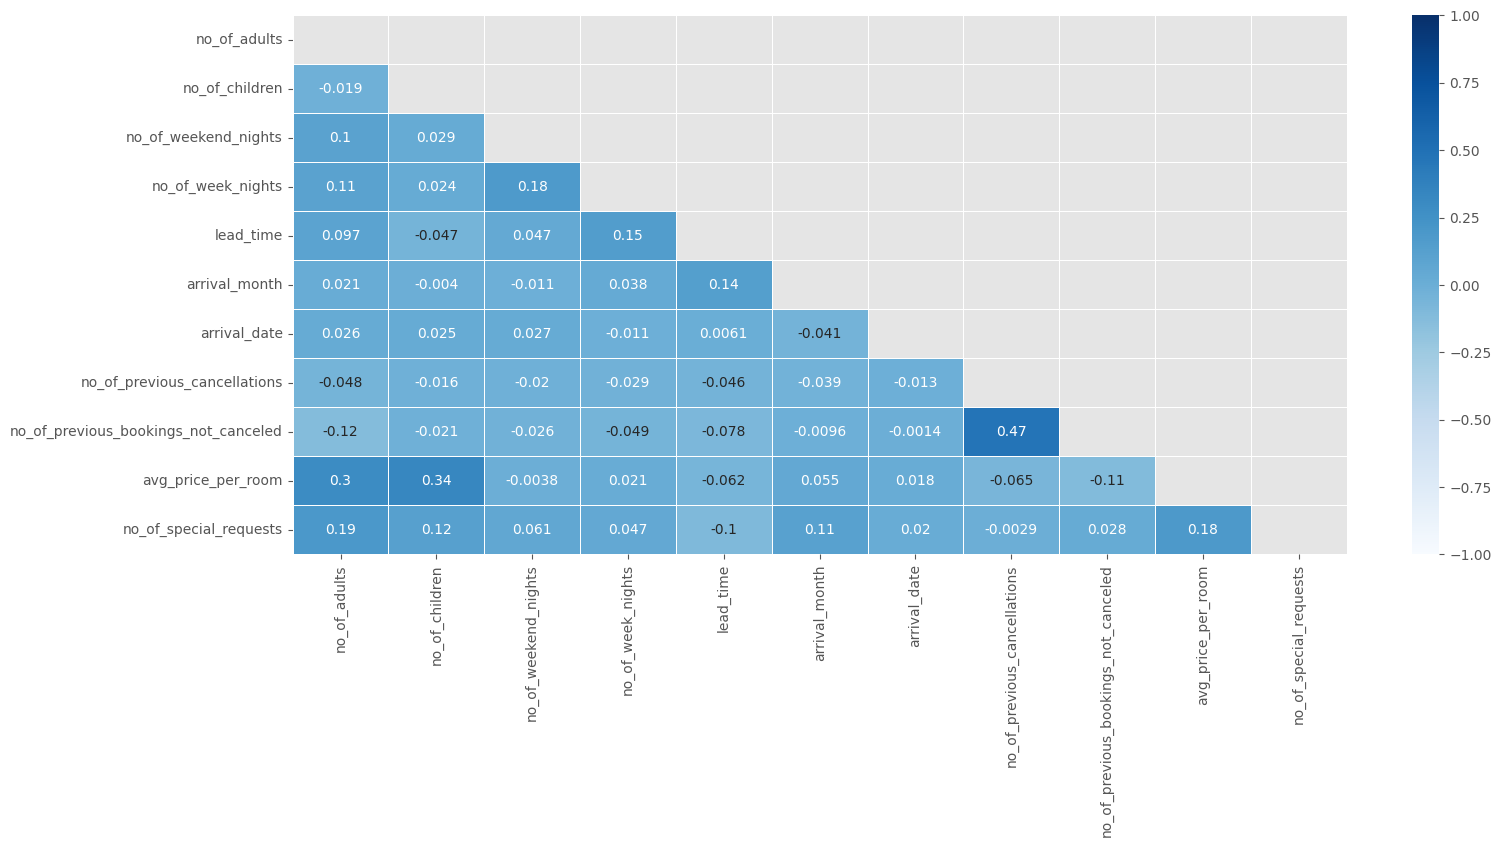

In [21]:
plt.figure(figsize=(17,7))
corr_mat = hotels[num_cols].corr()
sns.heatmap(corr_mat,annot=True, vmin = -1, vmax = +1, cmap = 'Blues', linewidths=.5,mask=np.triu(corr_mat))
plt.show()

## Search Method

In [22]:
num_imputer =  SimpleImputer(strategy="median")
scaler = StandardScaler()

num_features =num_imputer.fit_transform(hotels[num_cols])
num_features = scaler.fit_transform(num_features)

cat_imputer = SimpleImputer(strategy="most_frequent")
encoder = OneHotEncoder() 

cat_features = cat_imputer.fit_transform(hotels[cat_cols])
cat_features = encoder.fit_transform(cat_features)

num_features_df = pd.DataFrame(num_features, columns = hotels[num_cols].columns)
cat_features_df = pd.DataFrame(cat_features.toarray(), columns = encoder.get_feature_names(cat_cols))
processed_df = pd.concat([num_features_df, cat_features_df], axis=1)
processed_df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_Meal Plan 1,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,required_car_parking_space_0.0,required_car_parking_space_1.0,required_car_parking_space_nan,room_type_reserved_Room_Type 1,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,arrival_year_2017.0,arrival_year_2018.0,arrival_year_nan,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online,repeated_guest_0.0,repeated_guest_1.0,repeated_guest_nan,booking_status_Canceled,booking_status_Not_Canceled
0,0.296966,-0.26029,0.216781,-0.142559,-0.326431,0.186366,0.044481,-0.063325,-0.086851,-0.112464,-0.774299,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.296966,-0.26029,1.370667,0.574584,-0.934643,1.170750,-1.114999,-0.063325,-0.086851,0.095075,0.503692,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,-1.641222,-0.26029,1.370667,-0.859702,-0.981429,-1.782403,1.435856,-0.063325,-0.086851,-1.244891,-0.774299,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,0.296966,-0.26029,-0.937105,-0.142559,1.474815,-0.798018,0.508272,-0.063325,-0.086851,-0.096676,-0.774299,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0.296966,-0.26029,0.216781,-0.859702,-0.431698,-1.126146,-0.535259,-0.063325,-0.086851,-0.254556,-0.774299,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,2.235154,-0.26029,1.370667,-0.142559,0.001069,0.186366,-1.462842,-0.063325,-0.086851,1.849547,0.503692,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
36271,0.296966,-0.26029,0.216781,0.574584,1.673654,0.842622,0.160428,-0.063325,-0.086851,-0.356460,1.781684,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
36272,0.296966,-0.26029,1.370667,2.726014,0.737942,-0.141762,-1.694738,-0.063325,-0.086851,-0.142892,1.781684,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
36273,0.296966,-0.26029,-0.937105,0.574584,-0.256252,-1.126146,0.624220,-0.063325,-0.086851,-0.254556,-0.774299,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [23]:
processed_df.drop('booking_status_Canceled',axis=1, inplace=True)

In [24]:
processed_df = TabularDataset(processed_df)

In [25]:
predictor = TabularPredictor(label='booking_status_Not_Canceled').fit(processed_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20230427_041523/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230427_041523/"
AutoGluon Version:  0.7.0
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 20 12:51:02 UTC 2022
Train Data Rows:    36275
Train Data Columns: 36
Label Column: booking_status_Not_Canceled
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    56243.89 

[1000]	valid_set's binary_error: 0.128349


	0.8756	 = Validation score   (accuracy)
	10.39s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM ...
	0.8864	 = Validation score   (accuracy)
	4.21s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9008	 = Validation score   (accuracy)
	5.93s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.8972	 = Validation score   (accuracy)
	6.2s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ...
	0.8808	 = Validation score   (accuracy)
	26.98s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.89	 = Validation score   (accuracy)
	4.38s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.8904	 = Validation score   (accuracy)
	4.45s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8669	 = Validation score   (accuracy)
	115.01s	 = Training   runtime
	0.18s

### Select Model

In [26]:
predictor.leaderboard(processed_df, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.988725,0.905238,57.021564,3.515970,27.177511,0.064103,0.003361,0.863255,2,True,14
1,RandomForestGini,0.988560,0.900840,1.047663,0.105719,5.925186,1.047663,0.105719,5.925186,1,True,5
2,RandomForestEntr,0.988312,0.897241,1.470121,0.100681,6.195522,1.470121,0.100681,6.195522,1,True,6
3,ExtraTreesEntr,0.987843,0.890444,1.266703,0.129400,4.450611,1.266703,0.129400,4.450611,1,True,9
4,ExtraTreesGini,0.987815,0.890044,1.258140,0.132078,4.376992,1.258140,0.132078,4.376992,1,True,8
5,KNeighborsDist,0.983680,0.848860,26.051591,1.834635,0.046886,26.051591,1.834635,0.046886,1,True,2
6,LightGBMLarge,0.963115,0.896042,1.416501,0.172755,10.657431,1.416501,0.172755,10.657431,1,True,13
7,XGBoost,0.937009,0.893643,0.807489,0.060916,4.422316,0.807489,0.060916,4.422316,1,True,11
8,CatBoost,0.913687,0.880848,0.029557,0.007382,26.983659,0.029557,0.007382,26.983659,1,True,7
9,LightGBM,0.913136,0.886445,0.620881,0.091364,4.211591,0.620881,0.091364,4.211591,1,True,4


### Important features on expecting booking status

In [27]:
feature_im = predictor.feature_importance(processed_df)
feature_im

Computing feature importance via permutation shuffling for 36 features using 5000 rows with 5 shuffle sets...
	1501.82s	= Expected runtime (300.36s per shuffle set)
	1273.54s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
lead_time,0.23668,0.004249,1.245659e-08,5,0.245428,0.227932
no_of_special_requests,0.16696,0.009634,1.324271e-06,5,0.186796,0.147124
avg_price_per_room,0.12388,0.006488,8.994748e-07,5,0.137239,0.110521
arrival_month,0.08448,0.004228,7.500034e-07,5,0.093185,0.075775
arrival_date,0.05532,0.003264,1.447112e-06,5,0.062040,0.048600
no_of_weekend_nights,0.04804,0.002816,1.409646e-06,5,0.053838,0.042242
market_segment_type_Online,0.04380,0.002445,1.161139e-06,5,0.048835,0.038765
no_of_week_nights,0.04332,0.003142,3.297598e-06,5,0.049789,0.036851
no_of_adults,0.02816,0.001472,8.936917e-07,5,0.031192,0.025128
market_segment_type_Offline,0.01668,0.002221,3.683388e-05,5,0.021253,0.012107


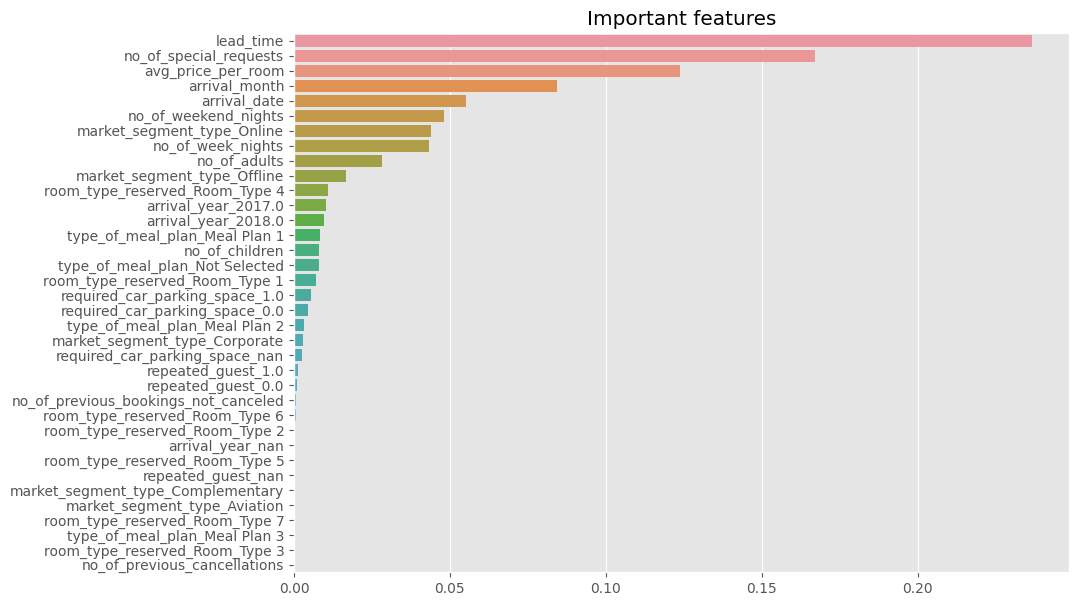

In [28]:
plt.figure(figsize=(10,7))
sns.barplot(data = feature_im, x='importance', y =feature_im.index)
plt.title('Important features')
plt.xlabel('')
plt.show()